In [1]:
from import_images import getImages
from import_model import getModel
from make_predictions import makePredictions
import numpy as np

import torch

from cellpose import resnet_torch
from cellpose import transforms
from cellpose import utils
import cv2

import time

from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import numpy as np

import matplotlib.pyplot as plt

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
images = getImages(images_directory)

directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
cellpose_model = getModel(directory)

In [3]:
#get model
directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
cpnet.load_model(directory)

#size at which we rescale the image so that the size of the nucleis match the size the cellpose models needs
rescale = cpnet.diam_mean/cpnet.diam_labels


In [4]:
def get_pre_activations(image,cpnet):
    rescale = cpnet.diam_mean/cpnet.diam_labels
    shape1, shape2 = image.shape[0], image.shape[1]

    x = transforms.resize_image(image, rsz=rescale,no_channels=True)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    x = np.concatenate((x, x), axis=0)
    x = torch.from_numpy(x)
    x = x.unsqueeze(0)

    y, style = cpnet(x)
    y = y.squeeze(0)
    y = y.cpu().detach().numpy()

    return y

In [5]:
training_images = images
training_probability_maps, training_cell_masks = makePredictions(images, cellpose_model)
training_pre_activations = []
for image in training_images:
    training_pre_activations.append(get_pre_activations(image,cpnet))

a
a
a
a
a
a
a
a
a
a
a


In [6]:
print(np.unique(training_pre_activations[2]))

print(np.unique(training_pre_activations[2]-np.min(training_pre_activations[2]))/(np.max(training_pre_activations[2])-np.min(training_pre_activations[2])))

[-16.653835 -16.53738  -16.5023   ...  33.636337  33.734863  34.601616]
[0.         0.00227205 0.00295647 ... 0.9811673  0.98308957 1.        ]


In [8]:
class ImageDataset(Dataset):
    def __init__(self, image, cellprob, cellmask):
        self.image = image
        self.cellprob = cellprob
        self.cellmask = cellmask

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        cellprob = self.cellprob[idx]
        cellmask = self.cellmask[idx]
        return img, cellprob, cellmask
    
def split_image_set(set):
    splitted = []
    for image in set:
        for i in range(0, image.shape[0], 268):
            for j in range(0, image.shape[0], 268):
                sub_img = image[i:i+268, j:j+268]
                splitted.append(sub_img)
    return splitted

#normalise the training_images
training_images = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in training_images]
#normalise the probability maps
#pm_normalised = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in training_pre_activations]
#pm_normalised = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in training_pre_activations]

#binarise the cell masks
cm_binary = [np.where(image > 0, 1.0, 0.0) for image in training_cell_masks]

#pad the images, probability maps and cell masks to 1024x1024
#images_pad = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in training_images]
#pm_norm_pad = [np.pad(img,((0, 0), (0,1024-img.shape[1]),(0,1024-img.shape[2]) ),mode='constant',constant_values=0) for img in training_pre_activations]
#cm_bin_pad = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in cm_binary]

images_pad = []
for image in training_images:
    images_pad.append(cv2.resize(image, dsize=(536, 536), interpolation=cv2.INTER_NEAREST))
cm_bin_pad = []
for image in cm_binary:
    cm_bin_pad.append(cv2.resize(image, dsize=(536, 536), interpolation=cv2.INTER_NEAREST))

#split the images, probability maps and cell masks into 256x256 images
images_pad_split = split_image_set(images_pad)
pm_norm_pad_split = []
for image in training_pre_activations:
    for i in range(0, 536, 268):
        for j in range(0, 536, 268):
            sub_img = image[:, i:i+268, j:j+268]
            pm_norm_pad_split.append(sub_img)
cm_bin_pad_split = split_image_set(cm_bin_pad)

#augment with rotations
images_rotated = []
pm_rotated = []
cm_rotated = []
for i in range(len(images_pad_split)):
    for j in range(1,4):
        images_rotated.append(np.rot90(images_pad_split[i],j))
        pm_rotated.append(np.rot90(pm_norm_pad_split[i], j, axes=(1, 2)))
        cm_rotated.append(np.rot90(cm_bin_pad_split[i],j))

#remove the images from cm_bin_pad_split that only have 0s, and remove them from images_pad_split and pm_norm_pad_split
images_pad_split_filtered = [images_rotated[i] for i in range(len(cm_rotated)) if np.sum(cm_rotated[i]) > 0]
pm_norm_pad_split_filtered = [pm_rotated[i] for i in range(len(cm_rotated)) if np.sum(cm_rotated[i]) > 0]
cm_bin_pad_split_filtered = [img for img in cm_rotated if np.sum(img) > 0]

print(len(images_pad_split_filtered), len(pm_norm_pad_split_filtered), len(cm_bin_pad_split_filtered))

images_torch = [torch.from_numpy(np.array(images_pad_split_filtered[i])) for i in range(len(images_pad_split_filtered))]

pm_torch = []
for i in range(len(pm_norm_pad_split_filtered)):
    pm_torch.append(torch.from_numpy(np.array(pm_norm_pad_split_filtered[i])))

cm_torch = [torch.from_numpy(np.array(cm_bin_pad_split_filtered[i])) for i in range(len(cm_bin_pad_split_filtered))]

132 132 132


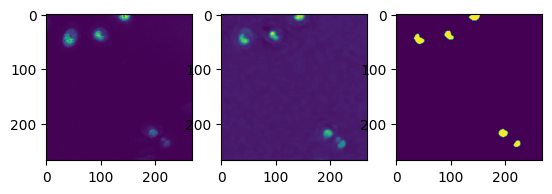

In [9]:

index = np.random.randint(0, len(images_torch))
#index = 0
plt.subplot(1,3,1)
plt.imshow(images_torch[index])
plt.subplot(1,3,2)
plt.imshow(pm_torch[index][2])
plt.subplot(1,3,3)
plt.imshow(cm_torch[index])
plt.show()

In [10]:
unet = UNet(nbClasses=3)
test = unet(torch.rand(1, 1, 268, 268))

print(test.shape)

torch.Size([1, 3, 268, 268])


In [11]:
train_dataset = ImageDataset(images_torch[:1], pm_torch[:1], cm_torch[:1])
print(len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


1


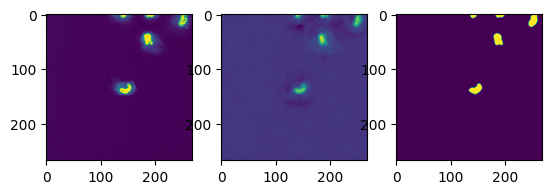

In [12]:
plt.subplot(1,3,1)
plt.imshow(images_torch[0])
plt.subplot(1,3,2)
plt.imshow(pm_torch[0][2])
plt.subplot(1,3,3)
plt.imshow(cm_torch[0])
plt.show()

In [13]:
print(torch.unique(cm_torch[0]))

tensor([0., 1.], dtype=torch.float64)


In [14]:
print(np.unique(pm_torch[0]))

[-14.460893  -14.409637  -14.3321295 ...  24.381422   24.653845
  25.005152 ]


In [15]:

class KDLoss(torch.nn.Module):
    def __init__(self, alpha=1.0, beta = 0.0, temperature=1):
        super(KDLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.temperature = temperature

    def forward(self, y_pred_logits, y_pred_mask, y_cp_true, y_cm_true):
        #print(y_pred_logits.shape, y_pred_mask.shape, y_cp_true.shape, y_cm_true.shape)
        
        #y_pred_sig = torch.sigmoid(y_pred_logits)
        #y_pred_bin = torch.where(y_pred_sig > 0.5, 1.0, 0.0)
        #cast y_pred_bin to float
        #y_pred_bin = y_pred_bin.type(torch.FloatTensor)
        #print(y_pred_logits.shape, y_cp_true.shape)
        y_cp_true_softmax = F.softmax(y_cp_true/self.temperature, dim=1)
        kd_loss = F.cross_entropy(y_pred_logits, y_cp_true_softmax)

        ce_loss = F.binary_cross_entropy(y_pred_mask.float(), y_cm_true.float())

        #binarised = torch.where(F.sigmoid(y_pred_logits) > 0.4, 1.0, 0.0)
        #ce_loss = F.binary_cross_entropy(binarised, y_cp_true)  # compute binary cross-entropy loss
        #loss = F.binary_cross_entropy_with_logits(y_pred_logits, y_cm_true)
        #y_pred_mask = torch.sigmoid(y_pred_logits)  # compute predicted probabilities
        #y_pred_mask = torch.where(y_pred_mask>0.4,1.0,0.0) # binarise
          # compute KL divergence loss
        
        loss = self.alpha * kd_loss + self.beta * ce_loss  # combine losses
        return loss

def denormalize(array, min_value, max_value):
    normalized_range = 1.0
    normalized_array = array
    denormalized_array = (normalized_array * (max_value - min_value)) + min_value
    return denormalized_array

def trainEpoch(unet, train_loader, loss_fn, optimiser, scheduler, epoch_num):
    time_start = time.time()
    
    unet.train()

    train_loss = 0
    for image, cellprob, cellmask in train_loader:
        (image,cellprob,cellmask) = (image.to('cuda:0'),cellprob.to('cuda:0'),cellmask.to('cuda:0')) # sending the data to the device (cpu or GPU)

        image = image.unsqueeze(1)
        pred = unet(image).squeeze(1) #make a prediction
        #print('pred shape', pred.shape)
        

        min_value = -16
        max_value = 34
        #pred = denormalize(pred, min_value, max_value)

        detranspose = (1,2,0)
        predicted_masks = []
        for p in pred:
            p = p.cpu().detach().numpy()
            p = denormalize(p, min_value, max_value)
            p = np.transpose(p, detranspose)
            p = utils.get_masks_unet(p, cell_threshold=2.0, boundary_threshold=0.5)
            p = utils.fill_holes_and_remove_small_masks(p, min_size=15)
            p = torch.from_numpy(p).to('cuda:0')
            predicted_masks.append(p)
        predicted_masks = torch.stack(predicted_masks).unsqueeze(1)
        #cellprob = torch.unsqueeze(cellprob,1)
        cellmask = torch.unsqueeze(cellmask,1)

        #if len(np.unique(predicted_masks.cpu().detach().numpy())) > 1:
        #    plt.subplot(1,2,1)
        #    plt.imshow(predicted_masks[0].cpu().detach().numpy()[0])
        #    plt.subplot(1,2,2)
        #    plt.imshow(cellmask[0].cpu().detach().numpy()[0])
        #    plt.show()

        #loss = loss_fn(pred, cellprob,10) # calculate the loss of that prediction
        
        #print(torch.unique(pred),torch.unique(predicted_masks),torch.unique(cellprob),torch.unique(cellmask))

        if 5 ==4:
            plt.subplot(1,4,1)
            plt.imshow(pred[0].cpu().detach().numpy()[0])
            plt.subplot(1,4,2)
            plt.imshow(predicted_masks[0].cpu().detach().numpy()[0])
            plt.subplot(1,4,3)
            plt.imshow(cellprob[0].cpu().detach().numpy()[0])
            plt.subplot(1,4,4)
            plt.imshow(cellmask[0].cpu().detach().numpy()[0])
            plt.show()
        
        loss = loss_fn(pred, predicted_masks.float(), cellprob, cellmask) # calculate the loss of that prediction
        #loss = loss_fn(pred, cellmask )
        train_loss += loss
    
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters
        if scheduler is not None:
            scheduler.step()
    train_loss = train_loss.item()/len(train_loader)

    if epoch_num is None:
        print('Training loss: ', train_loss, 'Time: ', time.time()-time_start)
    else:
        print('Epoch ', epoch_num, 'Training loss: ', train_loss, 'Time: ', time.time()-time_start)
    #plt.imshow(pred[0].cpu().detach().numpy()[0])
    #plt.show()

    return unet

unet = UNet(nbClasses=3)
unet = unet.to('cuda:0')
loss_fn = KDLoss()
#loss_fn = IoULoss()
# loss_fn = torchvision.ops.distance_box_iou_loss()
#loss_fn = DiceLoss()
optimiser = torch.optim.SGD(unet.parameters(), lr=0.1, momentum=0.1)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.001, max_lr=0.1)

num_epochs = 500

for epoch in range(num_epochs):
    unet = trainEpoch(unet, train_loader, loss_fn, optimiser, scheduler=scheduler, epoch_num=epoch)

Epoch  0 Training loss:  1.1059671640396118 Time:  0.31969761848449707
Epoch  1 Training loss:  1.1056904792785645 Time:  0.010966777801513672
Epoch  2 Training loss:  1.1051409244537354 Time:  0.009966135025024414
Epoch  3 Training loss:  1.1043223142623901 Time:  0.01096343994140625
Epoch  4 Training loss:  1.1032376289367676 Time:  0.008970022201538086
Epoch  5 Training loss:  1.1018942594528198 Time:  0.008969783782958984
Epoch  6 Training loss:  1.1003111600875854 Time:  0.012959480285644531
Epoch  7 Training loss:  1.0984896421432495 Time:  0.009976625442504883
Epoch  8 Training loss:  1.0964415073394775 Time:  0.008970260620117188
Epoch  9 Training loss:  1.0941720008850098 Time:  0.008969306945800781
Epoch  10 Training loss:  1.091700553894043 Time:  0.009969949722290039
Epoch  11 Training loss:  1.089038610458374 Time:  0.008966684341430664
Epoch  12 Training loss:  1.086200475692749 Time:  0.009966373443603516
Epoch  13 Training loss:  1.0831876993179321 Time:  0.010995149612

RuntimeError: cuDNN error: CUDNN_STATUS_EXECUTION_FAILED
You can try to repro this exception using the following code snippet. If that doesn't trigger the error, please include your original repro script when reporting this issue.

import torch
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.allow_tf32 = True
data = torch.randn([1, 32, 134, 134], dtype=torch.float, device='cuda', requires_grad=True)
net = torch.nn.Conv2d(32, 64, kernel_size=[2, 2], padding=[0, 0], stride=[2, 2], dilation=[1, 1], groups=1)
net = net.cuda().float()
out = net(data)
out.backward(torch.randn_like(out))
torch.cuda.synchronize()

ConvolutionParams 
    memory_format = Contiguous
    data_type = CUDNN_DATA_FLOAT
    padding = [0, 0, 0]
    stride = [2, 2, 0]
    dilation = [1, 1, 0]
    groups = 1
    deterministic = false
    allow_tf32 = true
input: TensorDescriptor 00000264BB4ECFA0
    type = CUDNN_DATA_FLOAT
    nbDims = 4
    dimA = 1, 32, 134, 134, 
    strideA = 574592, 17956, 134, 1, 
output: TensorDescriptor 00000264BB4ED0F0
    type = CUDNN_DATA_FLOAT
    nbDims = 4
    dimA = 1, 64, 67, 67, 
    strideA = 287296, 4489, 67, 1, 
weight: FilterDescriptor 00000263A92C10E0
    type = CUDNN_DATA_FLOAT
    tensor_format = CUDNN_TENSOR_NCHW
    nbDims = 4
    dimA = 64, 32, 2, 2, 
Pointer addresses: 
    input: 000000145C600000
    output: 000000140C470800
    weight: 000000140C9DEA00
Additional pointer addresses: 
    grad_output: 000000140C470800
    grad_weight: 000000140C9DEA00
Backward filter algorithm: 1


In [16]:
x = training_images[0][100:368,100:368]
x = torch.from_numpy(x).to('cuda:0')
x = x.unsqueeze(0)
x = x.unsqueeze(0)

unet = unet.to('cuda:0')
pred = unet(x).cpu().detach().numpy()[0]

def denormalize(array, min_value, max_value):
    normalized_range = 1.0
    normalized_array = array
    denormalized_array = (normalized_array * (max_value - min_value)) + min_value
    return denormalized_array

min_value = -17
max_value = 34
print(np.unique(pred))

#pred = denormalize(pred, min_value, max_value)

print(pred.shape[-1]>2)

print(pred.shape)
print(np.unique(pred))
#print(pred)

plt.subplot(1,3,1)
plt.imshow(pred[1])

detranspose = (1,2,0)
#p = pred.cpu().detach().numpy()
p = np.transpose(pred, detranspose)
p = utils.get_masks_unet(p, cell_threshold=0.0, boundary_threshold=0.0)
p = utils.fill_holes_and_remove_small_masks(p, min_size=15)

plt.subplot(1,3,2)
plt.imshow(p)

plt.subplot(1,3,3)
plt.imshow(training_cell_masks[0][100:368,100:368])

plt.show()


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
def denormalize(array, min_value, max_value):
    normalized_range = 1.0
    normalized_array = array
    denormalized_array = (normalized_array * (max_value - min_value)) + min_value
    return denormalized_array

# Example usage:
normalized_array = np.array([0, 0.13, 0.4, 0.677, 1])
min_value = -16
max_value = 32

# Denormalize the array
denormalized_array = denormalize(normalized_array, min_value, max_value)
print(denormalized_array)

[-16.     -9.76    3.2    16.496  32.   ]
